# v01

Here we look at appropriate parameterizations that can be computed quickly.  I'll start with just 3x3 kernels, and and my 3x3 blocks.


There are only 3 unique distances.  So this is 3 parameters for scalars.  2 parameters each for vectors.  And 5 parameters for matrix.  This is 12 parameters.

I will need to make sure this is batched appropriately so it can be computed quickly.

Actually because rotations commute in 2D, there are more degrees of freedom.

3 for scalar

4 each for distances

3 for identity, and 2*4 for outer product.

Total of 22 out of a total 36.  So this is half.

# v02
In v02 I'm just getting rid of some debugging stuf from v01


# v03

In v03 I'm making my network deeper, to be about 250k like resnet

# v04
In v04 I use batch norm. no cutout. use real resnet architecture

# v05

Add rotationally invariant norm and bias.

I added a rotationally invariant nonlinearity too.

I have added the rotationally invariant scale and bias to the bn layer.

I did not make bias rotationally invariant in the conv layer, but I never use this bias currently because it is always followed by batchnomrm.

TODO: a layer that goes from scalar fields to vector fields explicitly.



Note i set normalize to mean 0.5, std 0.5 like medmnist did.

note they use default 100 epochs, and reduce stepsize by 0.1 at .50 and .75.  They use adam and an initial learning rate of 1e-3.


For comparison, they used AUC from SKL.  And the averaged it over each label (i.e. one versus all).

For accuracy, they use skl accuracy_score, not balanced.

They also use batch size of 128.

Also, they use the "best model" on the validation set for testing.  This is the one with the best auc.

Another thing, in the medmnist paper they use 4 scales, with 2 repeats per scale.

I think I will likely need more epochs of training.

# v06

Here I will use four layers with two copies in resnet

In v05 and v06 I fixed my sigmoid rot

# v07


# v08

figured out why it was not rotationally invariant.

Need to do averaging when size is even, and skipping when size is odd.

In [2]:
import torch, torchvision
from torch.utils.data import DataLoader

import numpy as np

import matplotlib.pyplot as plt
%matplotlib widget
# use widget in vscode

plt.set_loglevel('critical')

from sklearn.metrics import roc_auc_score

from importlib import reload
import models # while updating code this is important

In [3]:
reload(models)
tv = models.ToVector()
x = torch.rand(3,4,8,7)
out = tv(x)
print(out.shape)
m = models.Conv2DRot3x3(12,6)
m(tv(x))
# this will print out the shape of c
#c = models.Conv2DRot(x.shape[1]*3,6,1)
#c(tv(x))

torch.Size([3, 12, 8, 7])


tensor([[[[ 0.3763,  0.4151,  0.4402,  ...,  0.6141,  0.5095,  0.2699],
          [ 0.4513,  0.6187,  0.6612,  ...,  0.7717,  0.5154,  0.4716],
          [ 0.5734,  0.6505,  0.5025,  ...,  0.4718,  0.6671,  0.3761],
          ...,
          [ 0.4297,  0.5543,  0.4383,  ...,  0.4602,  0.5055,  0.4491],
          [ 0.4738,  0.4562,  0.7099,  ...,  0.4356,  0.5338,  0.4422],
          [ 0.4531,  0.5863,  0.5598,  ...,  0.4809,  0.5367,  0.3288]],

         [[ 1.0412,  0.7944,  0.9140,  ...,  1.0117,  0.9342,  0.8485],
          [ 1.0282,  1.1212,  0.8508,  ...,  0.7115,  1.2162,  1.0479],
          [ 0.9345,  1.1840,  0.5758,  ...,  1.0671,  1.0542,  0.8833],
          ...,
          [ 1.0695,  1.0311,  0.8985,  ...,  1.0069,  1.0644,  1.1053],
          [ 1.2497,  0.8790,  0.9785,  ...,  1.0945,  0.8696,  0.8681],
          [ 1.1268,  1.2585,  1.1731,  ...,  1.2188,  1.3714,  0.9190]],

         [[ 0.2140,  0.1381,  0.5305,  ...,  0.2936,  0.2389,  0.3701],
          [ 0.1539,  0.4046,  

In [4]:
reload(models)
tv = models.ToVector()
x = torch.rand(3,4,8,7)
print(x.shape)
x = tv(x)
print(x.shape)
ksize = 5
m = models.Conv2DRot(x.shape[-3],6,ksize)
m(x)


print(models.count_parameters(m))
print(models.count_parameters(torch.nn.Conv2d(12,6,ksize)))


torch.Size([3, 4, 8, 7])
torch.Size([3, 12, 8, 7])
418
1806


In [5]:
x.ndim

4

In [6]:
count = 0
for p in m.parameters():
    count += p.numel()
count

418

In [7]:
def cutout(I,val=0.5):
    rows = np.random.randint(0,I.shape[-2],(2,))    
    rows.sort()
    cols = np.random.randint(0,I.shape[-1],(2,))    
    cols.sort()
    I[...,rows[0]:rows[1],cols[0]:cols[1]] = val
    return I

In [8]:
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


In [9]:
my_dataset = torchvision.datasets.CIFAR10(    
    '/home/dtward/data',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                              torchvision.transforms.RandomCrop(32,padding=4,padding_mode='edge'),
                                              torchvision.transforms.ToTensor(),                                              
                                             # torchvision.transforms.Lambda(cutout)
                                              normalize,
                                             ]
                                            )
)
my_loader = DataLoader(my_dataset, batch_size=64, num_workers=8, shuffle=True)

Files already downloaded and verified


In [10]:
my_dataset_test = torchvision.datasets.CIFAR10(    
    '/home/dtward/data',
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              normalize,
                                              ])
)
my_loader_test = DataLoader(my_dataset_test, batch_size=64, num_workers=8, shuffle=True)

Files already downloaded and verified


In [11]:
from medmnist import DermaMNIST

In [12]:
normalize = torchvision.transforms.Normalize(mean=0.5,
                                     std=0.5)
# 0.5, 0.5 is used in medmnist code

In [13]:
from medmnist import DermaMNIST as Dataset
from medmnist import BloodMNIST as Dataset
#from medmnist import PathMNIST as Dataset
#from medmnist import TissueMNIST as Dataset # really big
#from medmnist import BreastMNIST as Dataset # much smaller

In [14]:
my_dataset = Dataset(     
    download=True,
    split='train',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),   
                                              normalize
                                             ]
                                            )
)
my_loader = DataLoader(my_dataset, batch_size=128, num_workers=8, shuffle=True)

Using downloaded and verified file: /home/dtward/.medmnist/bloodmnist.npz


In [15]:
my_dataset_val = Dataset(        
    split='val',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              normalize,
                                             ]
                                            )
)
my_loader_val = DataLoader(my_dataset_val, batch_size=128, num_workers=8, shuffle=True)

In [16]:
my_dataset_test = Dataset(        
    split='test',    
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              normalize,
                                             ]
                                            )
)
my_loader_test = DataLoader(my_dataset_test, batch_size=128, num_workers=8, shuffle=True)
labels = set()
for x,l in my_loader_test:
    labels_i = {li.squeeze().item() for li in l}
    labels = labels.union(labels_i)
n_labels = len(labels)    
print(n_labels)

8


In [17]:

import importlib
import models
importlib.reload(models)

from models import Conv2DRot, ExtractScalar

In [18]:
# now for scalars b we need only 1 number per block, and the others need to be 0
x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)
c = torch.nn.Sequential(Conv2DRot(9,9,3,bias=False),ExtractScalar())
for p in c.parameters():
    p.requires_grad = False
# only extract the scalars
out = c(x)

out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

# okay these are the same to floating point accuracy

print(torch.max(torch.abs(out - out2)))

tensor(4.7684e-07)


tensor(9.5367e-07)


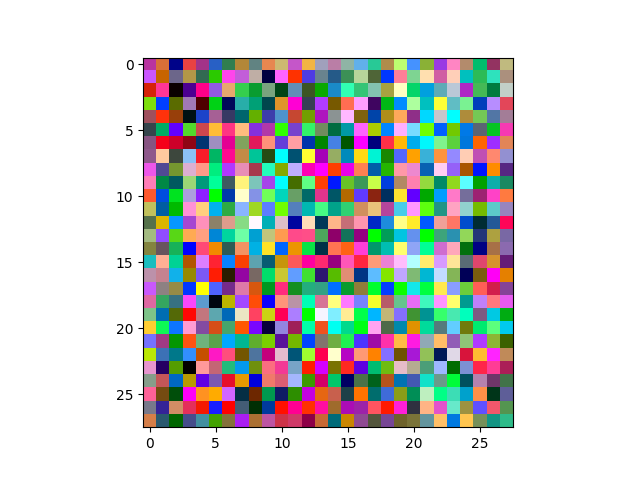

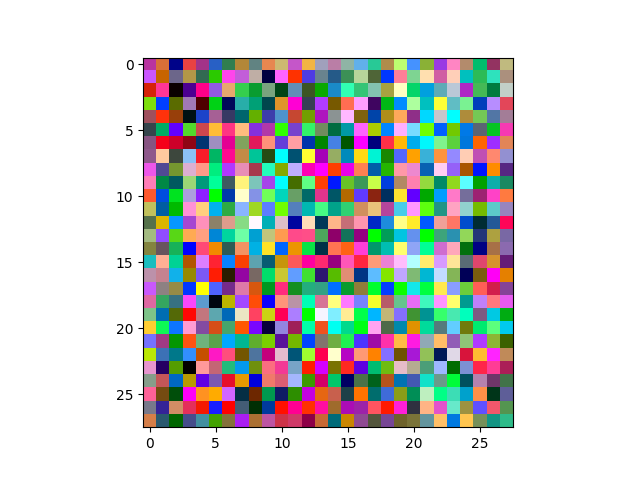

In [19]:
# now for scalars b we need only 1 number per block, and the others need to be 0
x = torch.randn(1,3,28,28)
x = tv(x)
c = torch.nn.Sequential(Conv2DRot(9,18,3,bias=False),Conv2DRot(18,9,3,bias=False),ExtractScalar())
for p in c.parameters():
    p.requires_grad = False
# only extract the scalars
out = c(x)

out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false

fig,ax = plt.subplots()
ax.imshow(out[0].permute(1,2,0)*0.5+0.5)
fig,ax = plt.subplots()
ax.imshow(out2[0].permute(1,2,0)*0.5+0.5)

print(torch.max(torch.abs(out-out2)))

In [20]:
# we need to check that the output is a rotated version of the input
# and we need to check that if our network uses the scalar part, the output is invariant

In [21]:
import importlib
import models
importlib.reload(models)
from models import BatchNormRot

tensor(1.9073e-06)


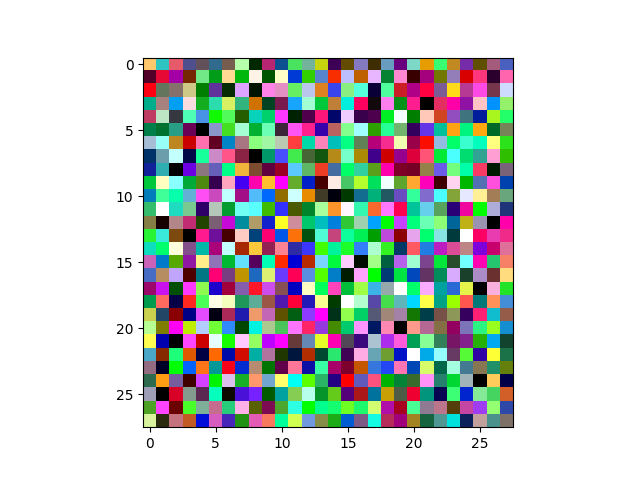

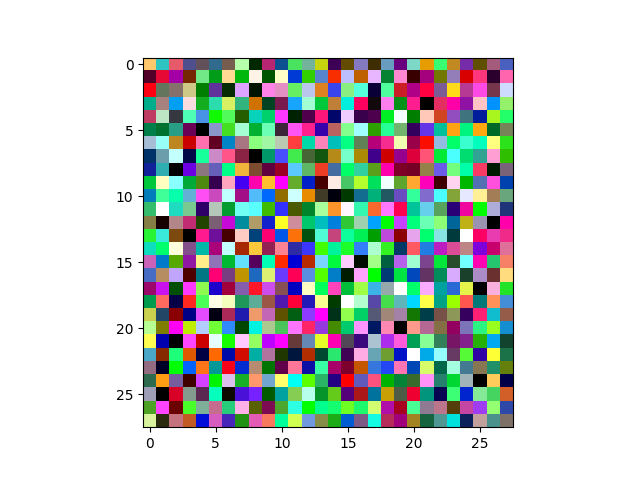

In [22]:
# check that the batchnorm preserves rotational invariance
kernel_size = 3
x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)
c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),BatchNormRot(18),Conv2DRot(18,9,kernel_size,bias=False),ExtractScalar())
for p in c.parameters():
    p.requires_grad = False
# only extract the scalars
out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)


out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)


out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)


out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

c.eval()
out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false

fig,ax = plt.subplots()
ax.imshow(out[0].permute(1,2,0)*0.5+0.5)
fig,ax = plt.subplots()
ax.imshow(out2[0].permute(1,2,0)*0.5+0.5)

print(torch.max(torch.abs(out-out2)))

In [23]:
import importlib
import models
importlib.reload(models)
from models import SigmoidRot, ZeroZero

tensor(2.3842e-07)


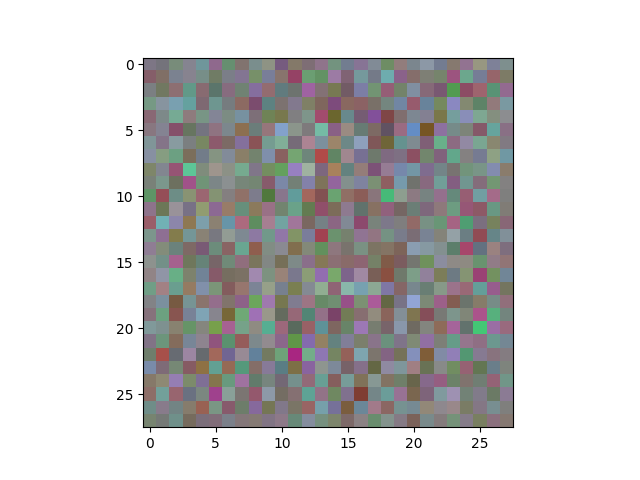

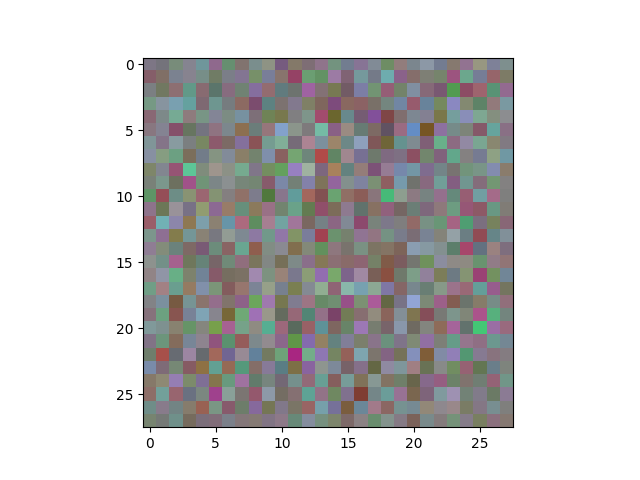

In [24]:
# check rotational invariance
kernel_size = 3
x = torch.randn(1,3,28,28)
z = torch.zeros(1,1,28,28)
x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),BatchNormRot(18),SigmoidRot(),Conv2DRot(18,9,kernel_size,bias=False),ExtractScalar())
for p in c.parameters():
    p.requires_grad = False

    
    
c.eval()
out = c(x)
out2 = c(x.rot90(1,dims=(-1,-2))).rot90(-1,dims=(-1,-2))

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false

fig,ax = plt.subplots()
ax.imshow(out[0].permute(1,2,0)*0.5+0.5)
fig,ax = plt.subplots()
ax.imshow(out2[0].permute(1,2,0)*0.5+0.5)

print(torch.max(torch.abs(out-out2)))    
    

In [25]:
from IPython import display


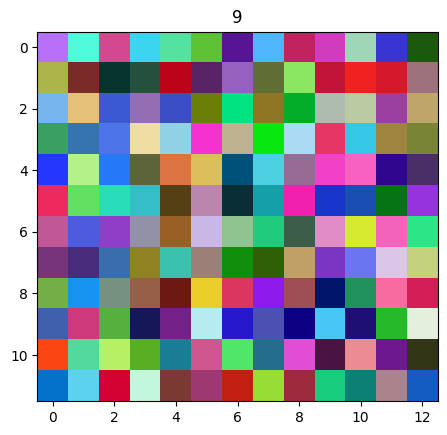

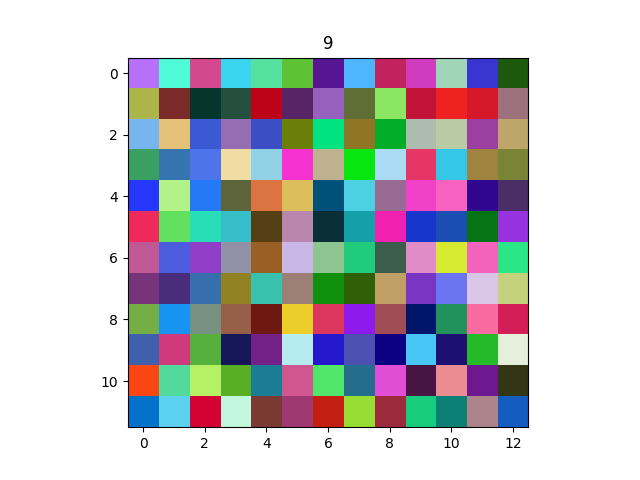

In [26]:
from IPython.display import clear_output, display
%matplotlib widget
fig,ax = plt.subplots()
for it in range(10):
    #clear_output(wait=True)    
    ax.cla()
    ax.imshow(np.random.rand(12,13,3))
    ax.set_title(it)
    #fig.canvas.draw()
    #plt.show()
    clear_output(wait=True)
    display(fig)

In [27]:
# check rotational invariance
kernel_size = 3
c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),BatchNormRot(18),SigmoidRot(),Conv2DRot(18,9,kernel_size, bias=False),ExtractScalar(),torch.nn.AvgPool2d(28),ZeroZero(),torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(1.7881e-07)


In [28]:
# check rotational invariance
kernel_size = 3
c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,36,kernel_size,bias=False),
                        BatchNormRot(36),
                        SigmoidRot(),
                        Conv2DRot(36,18,kernel_size, bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,9,kernel_size,bias=False),
                        ExtractScalar(),
                        torch.nn.AvgPool2d(28),
                        ZeroZero(),
                        torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
c[4].a += torch.randn_like(c[4].a)   
c[4].b += torch.randn_like(c[4].b)   
c[7].a += torch.randn_like(c[7].a)   
c[7].b += torch.randn_like(c[7].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(1.1921e-07)


In [29]:
# check rotational invariance
# this time with stride
# it seems the strided convolutions kind of break the rotational invariance

c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,36,kernel_size,stride=2,bias=False),
                        BatchNormRot(36),
                        SigmoidRot(),
                        Conv2DRot(36,18,kernel_size,stride=2,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,9,kernel_size,bias=False),
                        ExtractScalar(),
                        torch.nn.AvgPool2d(7),
                        ZeroZero(),
                        torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
c[4].a += torch.randn_like(c[4].a)   
c[4].b += torch.randn_like(c[4].b)   
c[7].a += torch.randn_like(c[7].a)   
c[7].b += torch.randn_like(c[7].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(0.0115)


In [30]:
importlib.reload(models)
from models import Down2Rot

In [31]:
# check rotational invariance
# this time with stride
# it seems the strided convolutions kind of break the rotational invariance
kernel_size = 3
c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,36,kernel_size,bias=False),
                        Down2Rot(),
                        BatchNormRot(36),
                        SigmoidRot(),
                        Conv2DRot(36,18,kernel_size,bias=False),
                        Down2Rot(),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,9,kernel_size,bias=False),
                        ExtractScalar(),
                        torch.nn.AvgPool2d(7),
                        ZeroZero(),
                        torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
c[5].a += torch.randn_like(c[5].a)   
c[5].b += torch.randn_like(c[5].b)   
c[9].a += torch.randn_like(c[9].a)   
c[9].b += torch.randn_like(c[9].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(7.4506e-09)


In [32]:
# check rotational invariance
# this time with stride
# it seems the strided convolutions kind of break the rotational invariance

c = torch.nn.Sequential(Conv2DRot(9,18,kernel_size,bias=False),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,36,kernel_size,bias=False),
                        torch.nn.AvgPool2d(2),
                        BatchNormRot(36),
                        SigmoidRot(),
                        Conv2DRot(36,18,kernel_size,bias=False),
                        Down2Rot(),
                        BatchNormRot(18),
                        SigmoidRot(),
                        Conv2DRot(18,9,kernel_size,bias=False),
                        ExtractScalar(),
                        torch.nn.AvgPool2d(7),
                        ZeroZero(),
                        torch.nn.Linear(3,10))
for p in c.parameters():
    p.requires_grad = False

c[1].a += torch.randn_like(c[1].a)   
c[1].b += torch.randn_like(c[1].b)   
c[5].a += torch.randn_like(c[5].a)   
c[5].b += torch.randn_like(c[5].b)   
c[9].a += torch.randn_like(c[9].a)   
c[9].b += torch.randn_like(c[9].b)   
for i in range(10):
    x = torch.randn(1,3,28,28)
    z = torch.zeros(1,1,28,28)
    x = torch.stack((x[:,0],z[:,0],z[:,0],x[:,1],z[:,0],z[:,0],x[:,2],z[:,0],z[:,0]),-3)

    if i == 9:
        c.eval()
    out = c(x)
    out2 = c(x.rot90(1,dims=(-1,-2)))

    

# again the same to floating point accuracy (e-7-e-9)
# only when bias is false


print(torch.max(torch.abs(out-out2)))    
    

tensor(0.)


In [33]:
# note it seems the downsampling breaks the rotational invariance
# i.e. if the last pixel gets left off
# the last pixel will depend on the rotation
# so if the size is even, we will want to average
# if the size is odd, we will want to skip

In [34]:
# what do I want to do?
# check the magnitude
# if it is less than k multiply the vector by 0
# if it is greater than k, multiply by 1?
# no that's not quite right
# that's kind o like relu
# if it's less than 0 multiply by0
# if it's greater than 0, multiply by 1
# the differences is the relu leads to a continuous function
# but this doesn't, or does it?

In [35]:
# test
np.mean( np.sum(np.random.randn(10000,2)**2,-1)  > 1.5)

0.4748

In [36]:
np.mean( np.sum(np.random.randn(10000,2)**2,-1)**0.5  > 1.1)

0.5471

In [37]:
np.sqrt(2)

1.4142135623730951

A 1x1 convolution is just multiply by a matrix
J(x) = AI(x)

If I is a scalar then it's trivially true

If I is a vector then
A RI(R^{-1}x)

A has to commute with R, that means it needs to be proportional to identity, or in 2D be any rotation.

In [38]:
device = 'cuda:0'

In [39]:

from models import train_and_eval

In [40]:
nepochs = 200

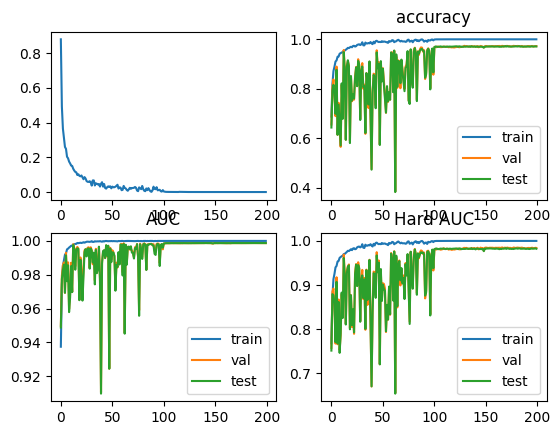

best auc, hard auc, accuracy
0.9987226147433745 0.9829084122032321 0.9710610932475884
final auc, hard auc, accuracy
0.9987260187054892 0.9823016712398853 0.9710610932475884


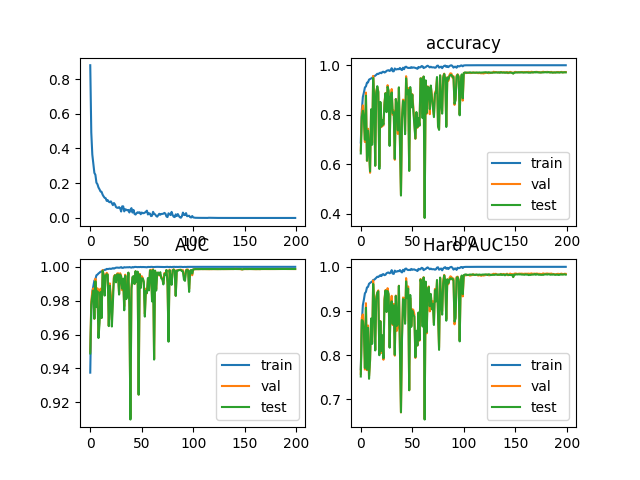

In [41]:
# 18 layers was used in the medmnist
# with 126 it does best, but its a bit more parameters than the resnet below
# I could try 123
reload(models)
net = models.RotNet18(n0=123,n1=n_labels)
# 126 gives 11 million parameters, the resnet below is only 10 million, so we could do a bit less
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 123
out['n_parameters'] = models.count_parameters(net)

In [42]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet18_n0123_out = out

In [43]:
out['accuracy_test'][-1]

0.9710610932475884

96

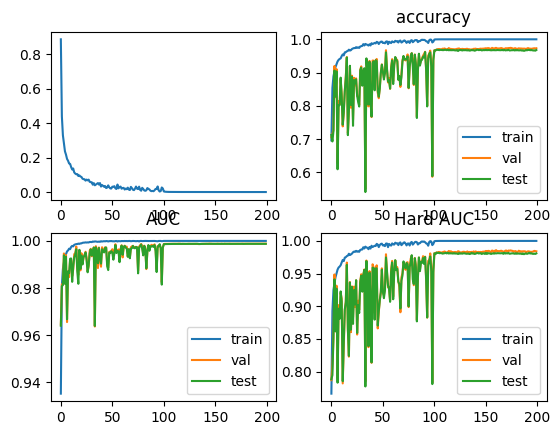

best auc, hard auc, accuracy
0.998762848107254 0.981717952118025 0.9681379713534054
final auc, hard auc, accuracy
0.9987556741800432 0.9809329927751049 0.9678456591639871


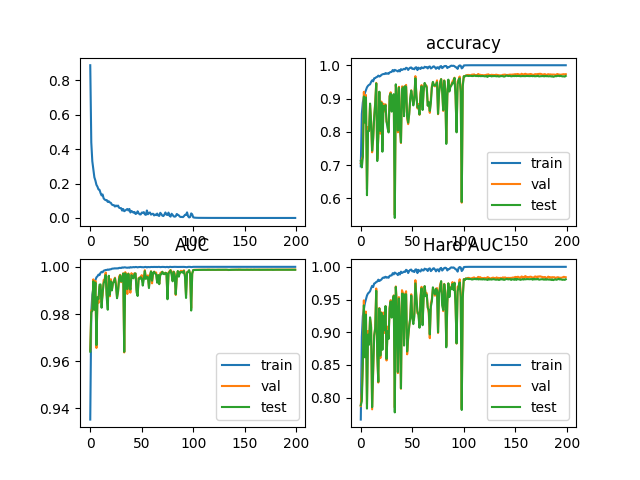

In [49]:
# 18 layers was used in the medmnist
# or let's try 32 scalars and 32 vectors (since they did 64 total), this would be 96 feature maps
# this is way less parameters
reload(models)
net = models.RotNet18(n0=96,n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 96
out['n_parameters'] = models.count_parameters(net)

In [50]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet18_n096_out = out

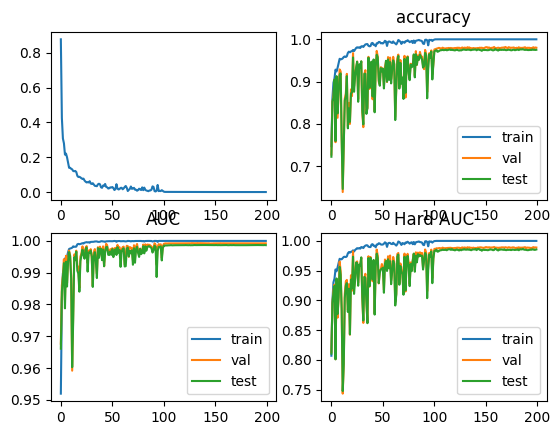

best auc, hard auc, accuracy
0.9986862512383194 0.9851610990908126 0.975445776088863
final auc, hard auc, accuracy
0.9986680814460114 0.9856331083150769 0.9751534638994446


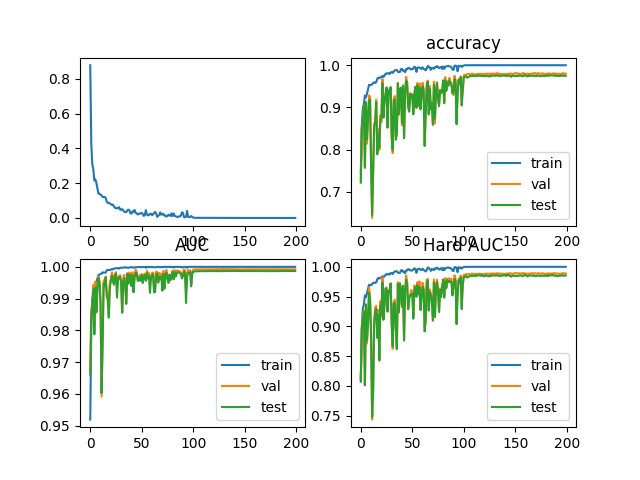

In [51]:
reload(models)
# this is the "default" which does 63 layers (close to 64, but less)
net = models.RotNet18(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 63
out['n_parameters'] = models.count_parameters(net)

In [52]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet18_out = out

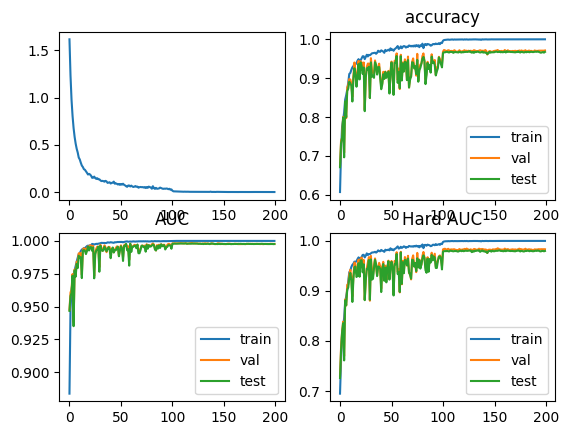

best auc, hard auc, accuracy
0.9979747646501875 0.9806972099656935 0.9672610347851506
final auc, hard auc, accuracy
0.9976607242433065 0.9798938069896257 0.9675533469745689


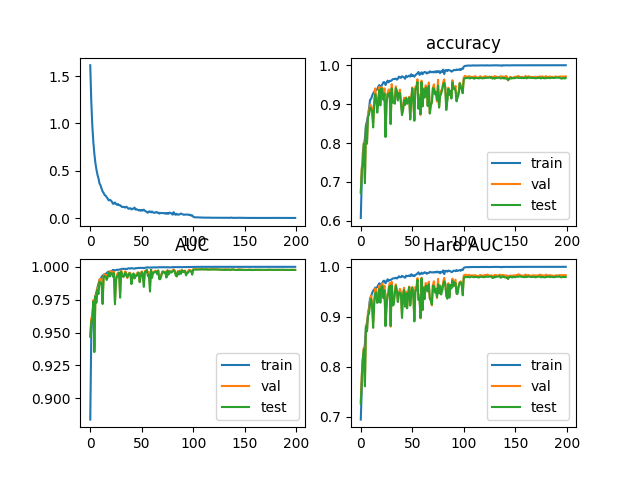

In [53]:
# 20 layers is from cifar
# default is 15 parameters, note this tends to be too little to do a good job
reload(models)
net = models.RotNet20(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 15
out['n_parameters'] = models.count_parameters(net)

In [55]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet20_out = out

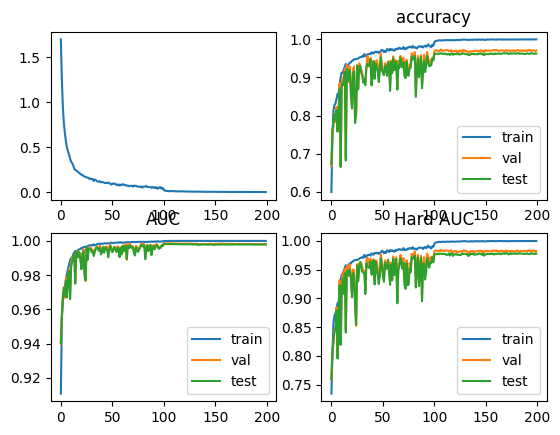

best auc, hard auc, accuracy
0.9981964179439783 0.977241176112441 0.9625840397544577
final auc, hard auc, accuracy
0.997863897577351 0.9777085794232585 0.9625840397544577


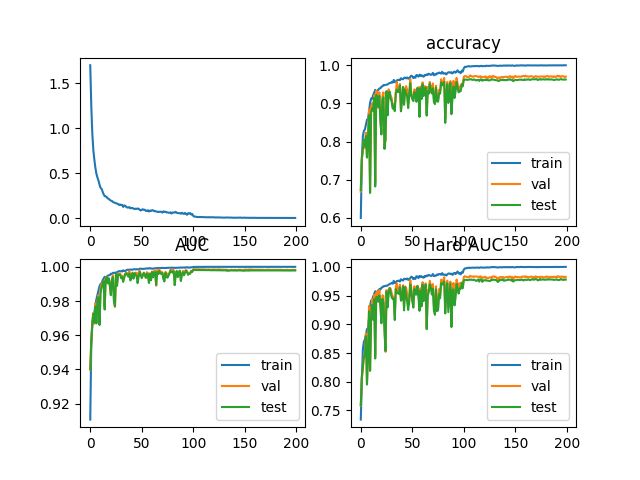

In [74]:
# 20 layers is from cifar
# default is 15 parameters, note this tends to be too little to do a good job
# try with reflection equivariance too, it's way fewer parameters
reload(models)
net = models.RotNet20(n1=n_labels,reflection=True)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 15
out['n_parameters'] = models.count_parameters(net)

In [75]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
refnet20_out = out

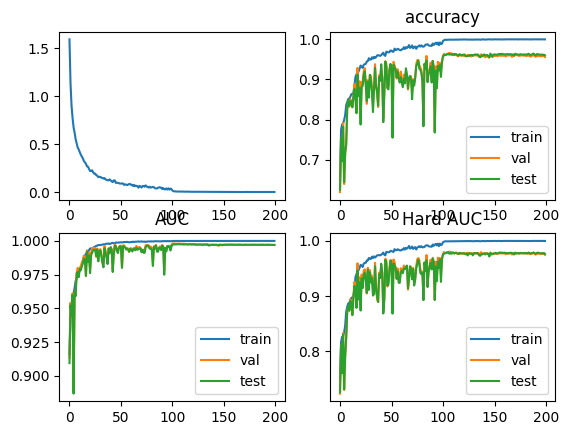

best auc, hard auc, accuracy
0.997436916244423 0.9767590322978149 0.9596609178602747
final auc, hard auc, accuracy
0.9970469454251927 0.9764532580324446 0.959953230049693


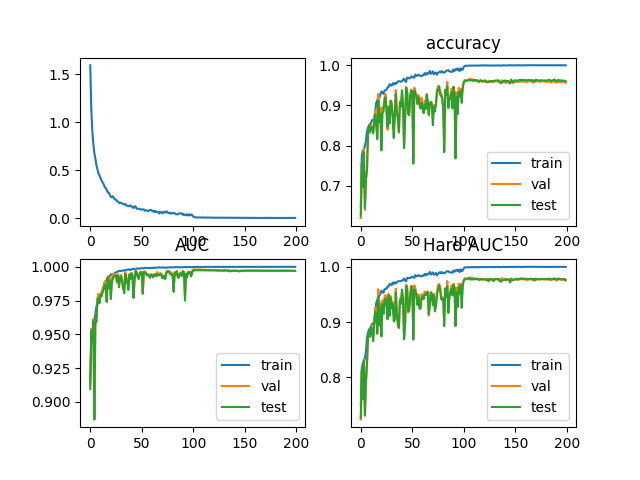

In [59]:
# 20 layers is from cifar, but lets try 5x5
reload(models)
net = models.RotNet20(n1=n_labels,kernel_size=5)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 15
out['n_parameters'] = models.count_parameters(net)

In [60]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet20_5x5_out = out

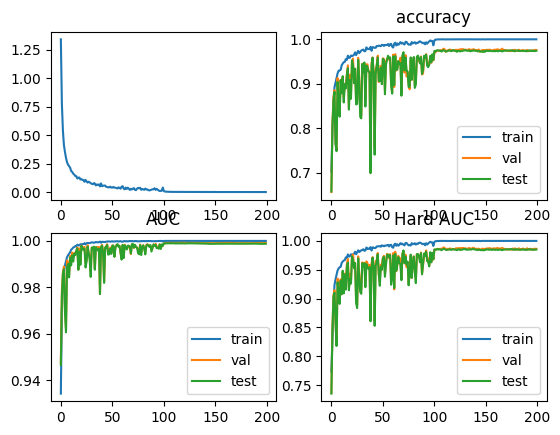

best auc, hard auc, accuracy
0.9989222089525482 0.9851613499809674 0.9751534638994446
final auc, hard auc, accuracy
0.9987682827813569 0.9850799248541794 0.9742765273311897


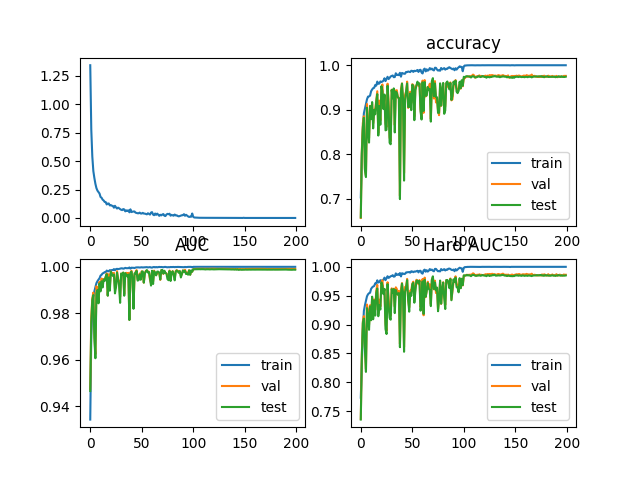

In [61]:
# 20 layers is from cifar
# extra channels so it matches parameters
# below is about 400K
net = models.RotNet20(n0=36,n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 36
out['n_parameters'] = models.count_parameters(net)

In [62]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet20_n036_out = out

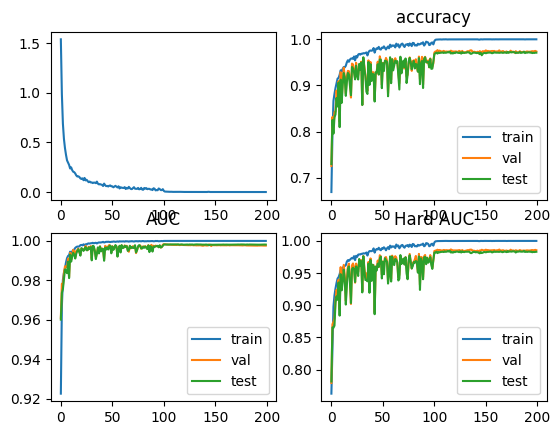

best auc, hard auc, accuracy
0.9982023961501628 0.981955979385189 0.9678456591639871
final auc, hard auc, accuracy
0.9981310114247685 0.983120569271411 0.9710610932475884


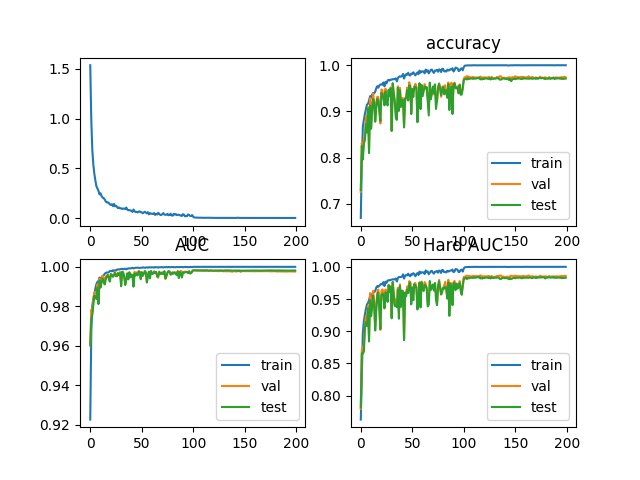

In [63]:
# 20 layers is from cifar
# instead of matching parameters, match the number of scalar + vector components
# the resnet20 uses 16 channels, so I'll do 8 scalar and 8 vector for 24 channels
net = models.RotNet20(n0=24,n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 24
out['n_parameters'] = models.count_parameters(net)

In [89]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet20_n024_out = out

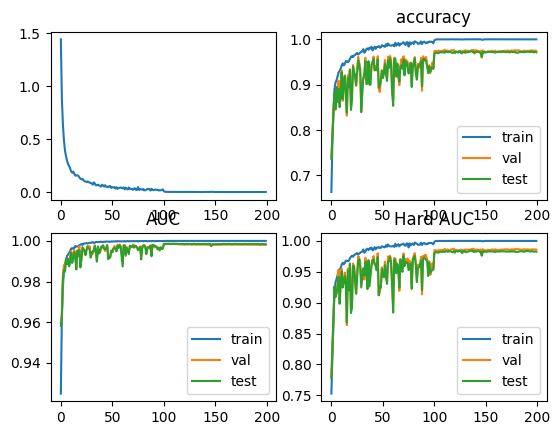

257478
best auc, hard auc, accuracy
0.9985029349719208 0.9825996083542863 0.9713534054370068
final auc, hard auc, accuracy
0.99837979813386 0.9825514731086967 0.9713534054370068


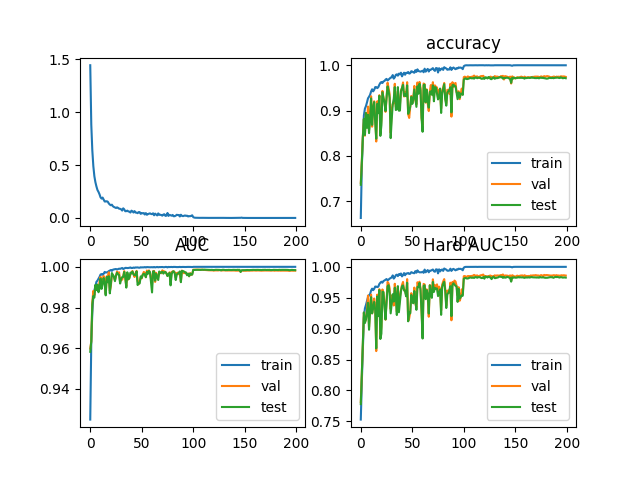

In [85]:
# TODO, do it again with the same number of parameters
# this is about 250K
# my resnet20 has 269722
# so here we will use 30 channels, for 257 parameters
net = models.RotNet20(n0=30,n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print(models.count_parameters(net)) # again because output gets deleted
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 30
out['n_parameters'] = models.count_parameters(net)

In [86]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
rotnet20_n030_out = out

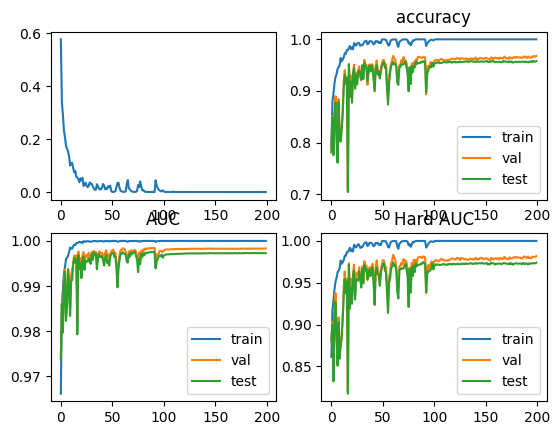

best auc, hard auc, accuracy
0.9974894436919347 0.973762936202335 0.9567377959660918
final auc, hard auc, accuracy
0.9973090785026923 0.9740279808697017 0.957907044723765


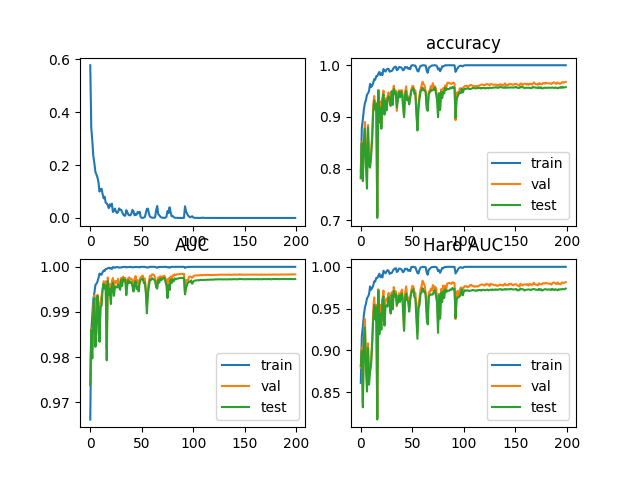

In [65]:
net = models.ResNet18(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 64
out['n_parameters'] = models.count_parameters(net)

In [66]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
resnet18_out = out

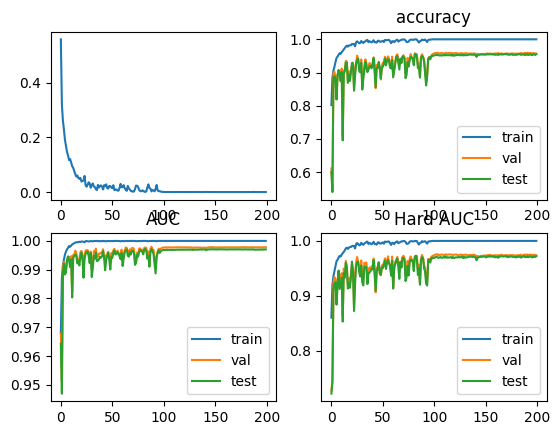

best auc, hard auc, accuracy
0.9971323840895934 0.970414367870163 0.9497223034200526
final auc, hard auc, accuracy
0.99705193953895 0.9723906127961945 0.9558608593978369


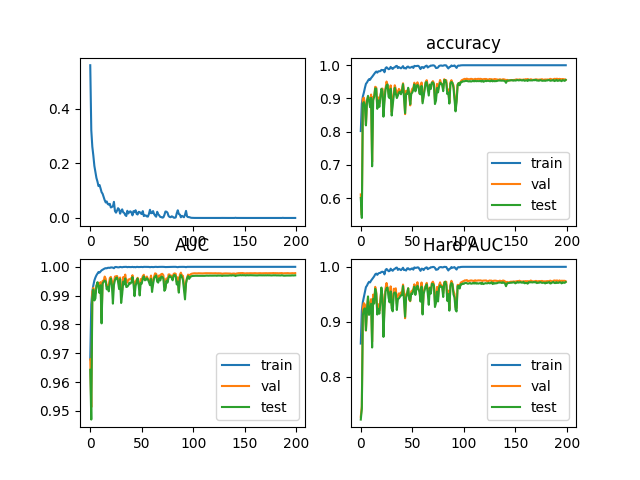

In [67]:
# this is the resnet from the resnet paper for cifar10
# it has 16 channels at its input layer, and about 267K parameters
net = models.ResNet20(n1=n_labels)
print(models.count_parameters(net))
out = train_and_eval(net,my_loader, my_loader_val, my_loader_test, device=device, nepochs=nepochs)
auc_val = out['auc_val']
auc_test = out['auc_test']
hard_auc_test = out['hard_auc_test']
accuracy_test = out['accuracy_test']
ind = auc_val.index(np.max(auc_val))
print('best auc, hard auc, accuracy')
print(auc_test[ind],hard_auc_test[ind], accuracy_test[ind])
print('final auc, hard auc, accuracy')
print(auc_test[-1],hard_auc_test[-1], accuracy_test[-1])
out['n0'] = 16
out['n_parameters'] = models.count_parameters(net)

In [68]:
out['net'] = None
import gc
gc.collect()
torch.cuda.empty_cache()
resnet20_out = out

# plot the data here

In [69]:
[k for k in out]

['fig',
 'net',
 'accuracy_test',
 'accuracy_val',
 'accuracy_train',
 'auc_test',
 'auc_val',
 'auc_train',
 'hard_auc_test',
 'hard_auc_val',
 'hard_auc_train',
 'n0',
 'n_parameters']

In [98]:
keys = ['accuracy_train', 'accuracy_val','accuracy_test', 
        'auc_train', 'auc_val', 'auc_test',
        'hard_auc_train', 'hard_auc_val', 'hard_auc_test']

# rotnet18 defaults to 63 channels, so doing 66 is not very differet
# rotnet20 had 15 channels efault
outputs = [resnet18_out,rotnet18_out,rotnet18_n0123_out,rotnet18_n096_out,resnet20_out, rotnet20_out,rotnet20_n024_out,rotnet20_n030_out,rotnet20_5x5_out,refnet20_out]
names = ['resnet18','rotnet18_63','rotnet18_96','rotnet18_123','resnet20', 'rotnet20_15','rotnet20_24','rotnet20_30','rotnet20_5x5','refnet20']



In [99]:


def plot_evaluation(names,outputs,measure):

    fig,ax = plt.subplots(1,2,sharey=True,sharex=True)

    k = '_'.join([measure,'test'])

    colors = ['r' if 'rot' in n else ('m' if 'ref' in n else 'b') for n in names]

    # this is the best
    data = []
    for out in outputs:
        ind = np.argmax(out[k.replace('test','val')])
        data.append(out[k][ind])
    
    ax[0].bar(names, data, color=colors)
    ax[0].set_ylim(np.min(data)-0.01,np.max(data)+0.01)
    for tick in ax[0].get_xticklabels():
        tick.set_rotation(30)
        tick.set_horizontalalignment('right')
    ax[0].set_title(f'{measure.upper()}, best on validation')

    # this is the last
    data1 = [out[k][-1] for out in outputs]
    ax[1].bar(names, data1, color=colors)
    #ax[1].set_ylim(np.min(data1)-0.01,np.max(data1)+0.01)
    ax[0].set_ylim(np.min(data+data1)-0.01,np.max(data+data1)+0.01)
    for tick in ax[1].get_xticklabels():
        tick.set_rotation(30)
        tick.set_horizontalalignment('right')
    ax[1].set_title(f'{measure.upper()}, last iteration')


    fig.subplots_adjust(bottom=0.15)
    return fig,ax

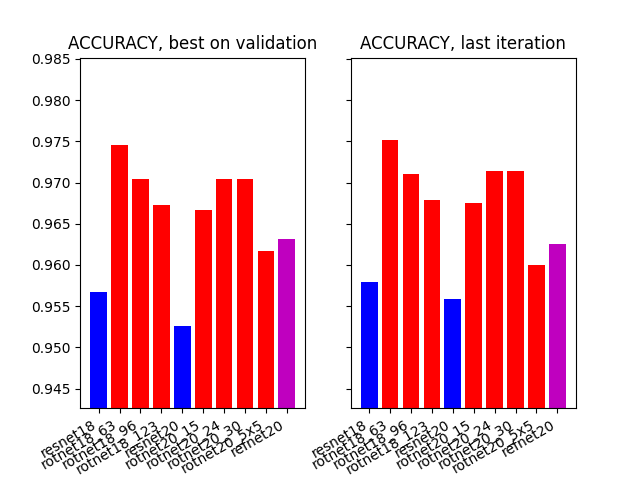

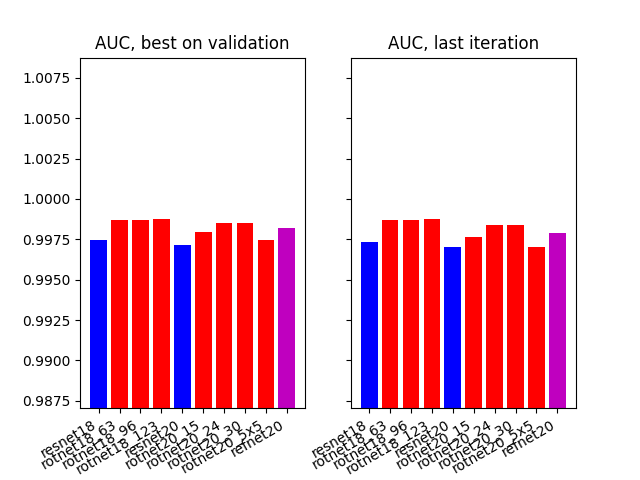

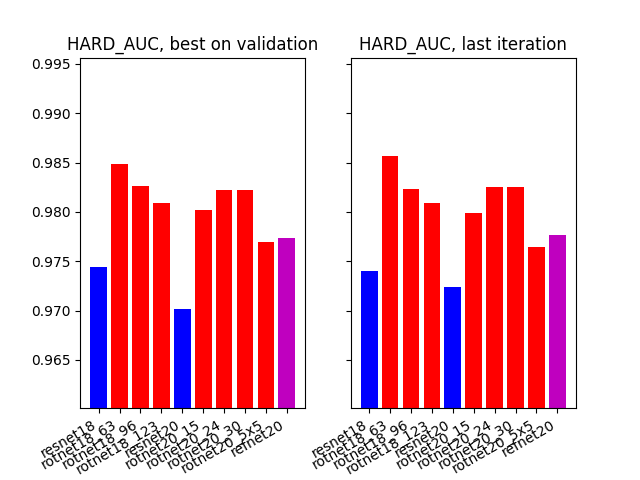

In [100]:
measures = ['accuracy','auc','hard_auc']
for measure in measures:
    fig,ax = plot_evaluation(names,outputs,measure)

# comparing
There are are a few ways we could compare models on "equal footing"

1. We could use the same number of feature maps.
1. We could use the same number of parameters
1. We could count vector components as one feature and then use the same number of feature maps.

# TODO
make sure outputs are saved.  They should be named according to their architecture.  The dataset they are trained on.  And which repeat they are.